In [1]:
import sys
import numpy as np
import time
import os
import sys
import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
map_size = 128
n_test = int(500)
n_epoch = 15
batch_size = 64
learning_rate = 1e-4

foreground_amplitude_rescale = 253775.
T_mean_cmb = 2.726*1e6

In [5]:
noisy_array = np.load('../foregrounds/foreground_synth_test.npy')
# noisy_array = noisy_array[:12000,:map_size,:map_size].astype(np.float32)
gc.collect()

for i in range(noisy_array.shape[0]):
    if i%(int(noisy_array.shape[0]/10))==0: print(i, flush=True)
    noisy_array[i,:,:] = ndimage.gaussian_filter(noisy_array[i,:,:], 1)
    

gc.collect()

noisy_array += -np.mean(noisy_array)
noisy_array *= 1/(10*np.std(noisy_array))
noisy_array += 0.5
noisy_array = np.reshape(noisy_array, (20,512,512,1))

0
2
4
6
8
10
12
14
16
18


In [6]:
clean_array = np.load('../foregrounds/map_256_041219.npy', mmap_mode='r+')
clean_array = clean_array[:12000].astype(np.float32)
gc.collect()

for i in range(clean_array.shape[0]):
    if i%(int(clean_array.shape[0]/10))==0: print(i, flush=True)
    clean_array[i,:,:,0] = ndimage.gaussian_filter(clean_array[i,:,:,0], 1)
gc.collect()

clean_array += -np.mean(clean_array)
clean_array *= 1./(10.*np.std(clean_array))
clean_array += 0.5

0
1200
2400
3600
4800
6000
7200
8400
9600
10800


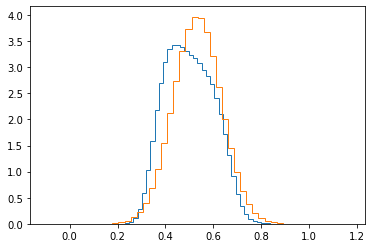

In [7]:
_ = plt.hist(noisy_array.flatten(), histtype='step',bins=50, density=True)
_ = plt.hist(clean_array.flatten(), histtype='step', bins=50, density=True)

In [8]:
# Make batch generator
def BatchGenerator2(noisy_array, clean_array, gen_batch_size=32):

    while True:
            index = np.random.randint(0, noisy_array.shape[0], gen_batch_size)
            cutout_1 = np.random.randint(0, 256, 1)[0]
            cutout_2 = np.random.randint(0, 256, 1)[0]
            noise = np.random.normal(0,0.05,(gen_batch_size,256,256,1))
            yield (noisy_array[index,cutout_1:(cutout_1+256),cutout_2:(cutout_2+256)]-0.5+clean_array[index] + noise,
                   clean_array[index])

train_gen = BatchGenerator2(noisy_array[:17], clean_array[:10000], gen_batch_size=batch_size)
test_gen = BatchGenerator2(noisy_array[17:], clean_array[10000:], gen_batch_size=batch_size)

In [15]:
i =0 
for x in train_gen:
    i = i+1
    print(i)
    if i>0:
        break

1


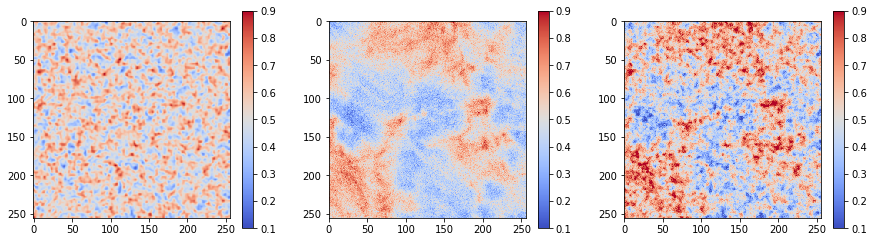

In [20]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(x[1][0,:,:,0], cmap='coolwarm',  clim=(0.1,0.9)), plt.colorbar()
_ = plt.subplot(132), plt.imshow(x[0][0,:,:,0]-x[1][0,:,:,0]+0.5,  clim=(0.1,0.9), cmap='coolwarm'), plt.colorbar()
_ = plt.subplot(133), plt.imshow(x[0][0,:,:,0], cmap='coolwarm',  clim=(0.1,0.9)), plt.colorbar()

In [21]:
cnn_instance = cnn.UnetlikeBaseline(map_size=256, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(clean_array[:10000].shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(clean_array[10000:].shape[0] / int(batch_size)))

gc.collect()

/obs/njeffrey/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
157/157 [==============================] - 63s 372ms/step - loss: 0.0487 - val_loss: 0.0076
Epoch 2/15
157/157 [==============================] - 58s 367ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 3/15
 29/157 [====>.........................] - ETA: 40s - loss: 0.0041

In [ ]:
test_output = cnn_model.predict(x[0])

In [ ]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(x[0][0,:,:,0], cmap='coolwarm',  clim=(0.1,0.9)), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_output[0,:,:,0],  clim=(0.1,0.9), cmap='coolwarm'), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_output[0,:,:,0]-x[0][0,:,:,0], cmap='coolwarm',  clim=(0.1,0.9)), plt.colorbar()